# Package Installation and Data Loading

In [ ]:
! pip3 install ripser

In [ ]:
! pip3 install gudhi

In [2]:
import pandas as pd
import numpy as np
import ripser
from persim import plot_diagrams
import networkx as nx
import matplotlib.pyplot as plt
import random
from sklearn.cluster import DBSCAN
import gudhi as gd
import math

## Construct Dataset and Set Filtration

In [3]:
# Create a dummy protein-protein interaction dataset

data = {
    'Protein1': ['A', 'A', 'B', 'B', 'C', 'D', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q'],
    'Protein2': ['B', 'C', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'A', 'B', 'C'],
    'Weight': [0.8, 0.9, 0.8, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 0.8, 0.6, 0.5, 0.7, 0.6, 0.9, 0.8, 0.5, 0.6, 0.7, 0.8]
}

ppi_df = pd.DataFrame(data)

# Create a dummy protein complex dataset
complexes = [['A', 'B', 'C'], ['D', 'E', 'F'], ['G', 'H', 'I', 'J'], ['K', 'L'], ['M', 'N', 'O'], ['P', 'Q']]


# Define the filtration parameter based on edge weights
filtration_parameter = 'Weight'


# Construct Network

In [4]:
import networkx as nx

# Create a graph from the PPI dataset
G = nx.Graph()
for index, row in ppi_df.iterrows():
    G.add_edge(row['Protein1'], row['Protein2'], weight=row['Weight'])

/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


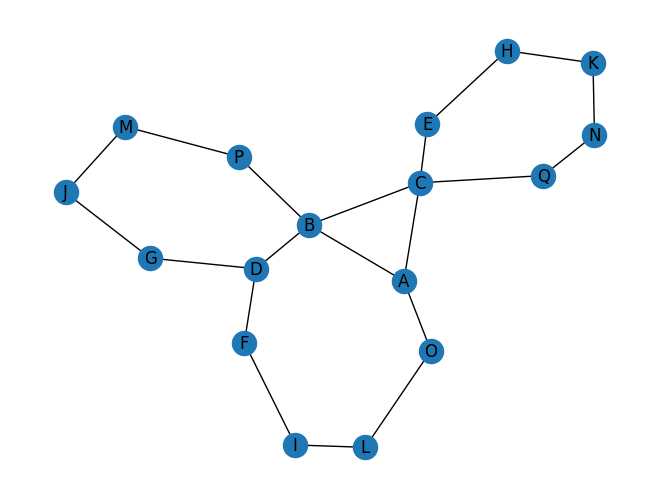

In [7]:
nx.draw_kamada_kawai(G, with_labels=True)

# Persistent Homology

## Vietoris Rips Filtration with Ripser

In [8]:
## Using the distance to consider the network as a metric space takes away from the features that could be extracted from the edge weights
## we could see how this reflects on the persistence diagrams
D = np.array(nx.floyd_warshall_numpy(G))
distance_mat_diags = ripser.ripser(D, distance_matrix=True)['dgms']

/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


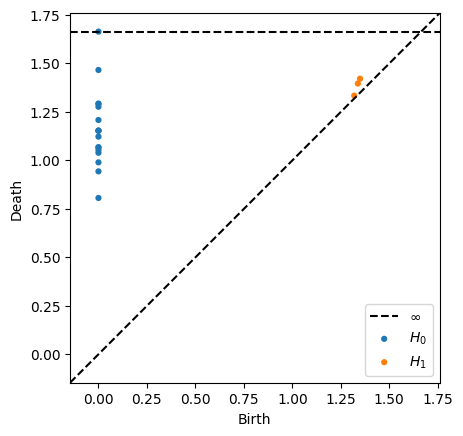

In [9]:
# Calculate persistent homology using Ripser
adj_mat_diags = ripser.ripser(nx.adjacency_matrix(G).toarray(), distance_matrix=False)['dgms']
plot_diagrams(adj_mat_diags)

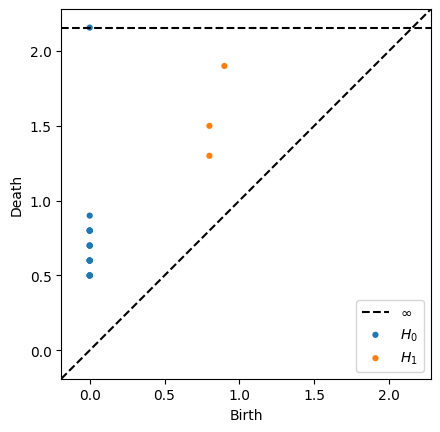

In [10]:
plot_diagrams(distance_mat_diags)

## Barcode Diagrams

In [11]:
## This is a customized function I wrote to plot the barcode specifically for Ripser package Persistence Diagrams
def plot_barcode(diag, dim, **kwargs):
    #dim = 0
    diag_dim = diag[dim]
    birth = diag_dim[:, 0]; death = diag_dim[:, 1]
    finite_bars = death[death != np.inf]
    if len(finite_bars) > 0:
        inf_end = 2 * max(finite_bars)
    else:
        inf_end = 2
    death[death == np.inf] = inf_end
    plt.figure(figsize=kwargs.get('figsize', (10, 5)))
    for i, (b, d) in enumerate(zip(birth, death)):
        if d == inf_end:
            plt.plot([b, d], [i, i], color='k', lw=kwargs.get('linewidth', 2))
        else:
            plt.plot([b, d], [i, i], color=kwargs.get('color', 'b'), lw=kwargs.get('linewidth', 2))
    plt.title(kwargs.get('title', 'Persistence Barcode'))
    plt.xlabel(kwargs.get('xlabel', 'Filtration Value'))
    plt.yticks([])
    plt.tight_layout()
    plt.show()

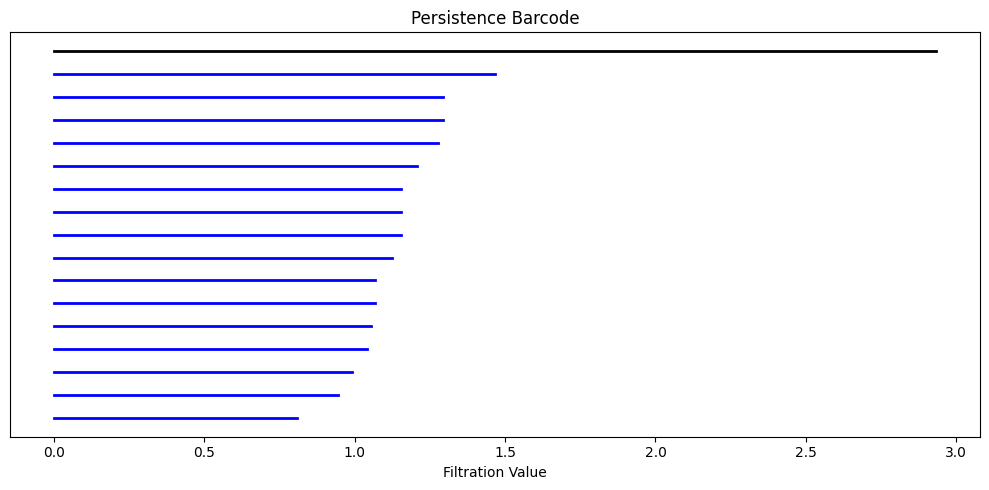

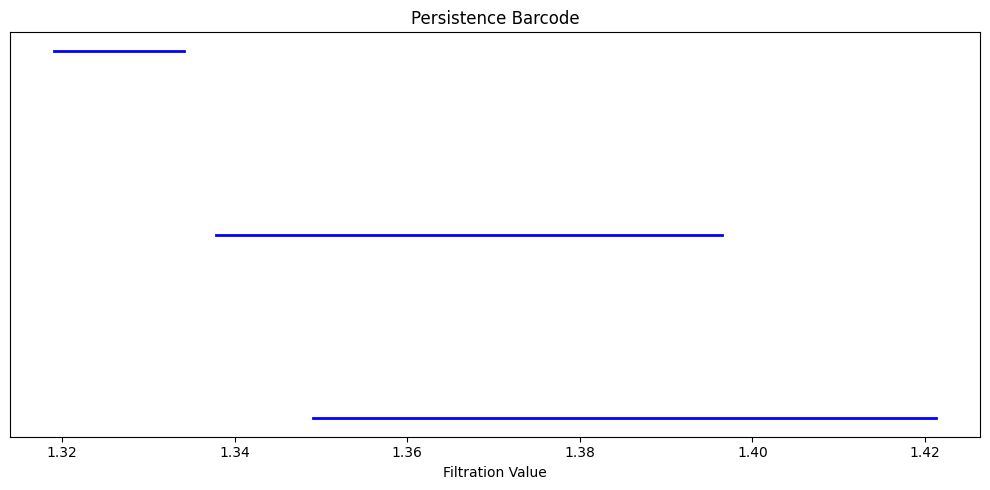

In [12]:
## The following are the barcode diagrams for the persistence diagrams extracted using the adjacency matrix fed into ripser (No distance)
## H_0
plot_barcode(adj_mat_diags, 0)
## H_1
plot_barcode(adj_mat_diags, 1)

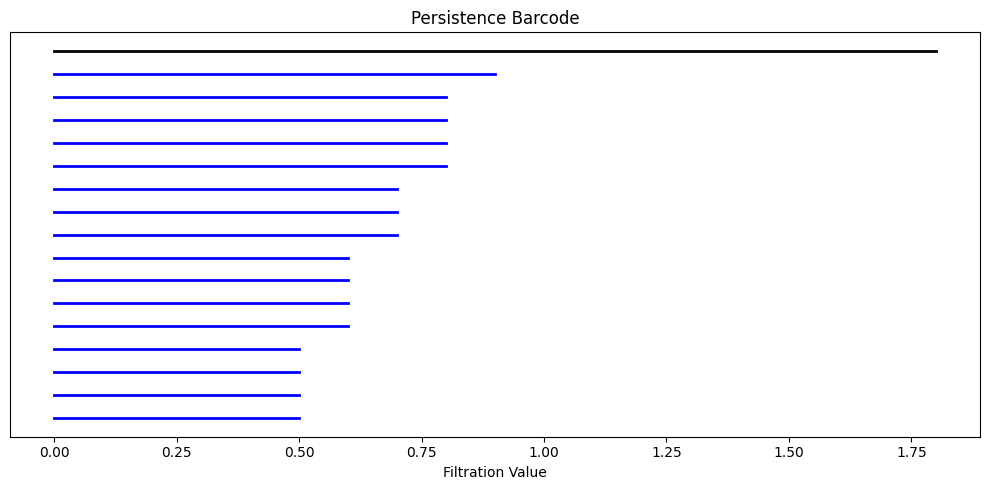

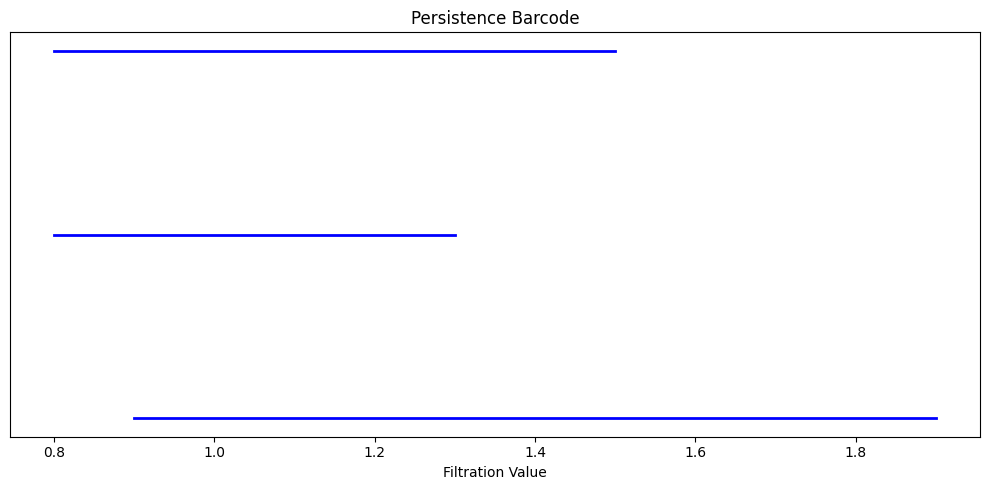

In [13]:
## The following are the barcode diagrams for the persistence diagrams extracted using the distance matrix for the dummy graph fed into ripser
## H_0
plot_barcode(distance_mat_diags, 0)
## H_1
plot_barcode(distance_mat_diags, 1)

## Betti Numbers

In [14]:
## IMPORTANT NOTE: The following was an initial attemp at using Betti numbers as a feature for single node classification.
    ## It is worthy to note that Betti numbers for different levels of filtration count the Homology rank for the entire network.
# Extract Betti numbers for the network at different levels of filtration for each protein
betti_numbers = {}
for i, protein in enumerate(G.nodes):
    betti_numbers[i] = {
        'betti_0': 0,  # Initialize with 0 Betti_0
        'betti_1': 0   # Initialize with 0 Betti_1
    }

for h_i, dgm in enumerate(distance_mat_diags):
    for idx, pt in enumerate(dgm):
        if pt[1] != np.inf:
            if h_i == 0:
                betti_numbers[idx]['betti_0'] += 1
            elif h_i == 1:
                betti_numbers[idx]['betti_1'] += 1


In [15]:
## Check betti numbers at different levels of homology
for k, v in betti_numbers.items():
  print(k, v)

0 {'betti_0': 1, 'betti_1': 1}
1 {'betti_0': 1, 'betti_1': 1}
2 {'betti_0': 1, 'betti_1': 1}
3 {'betti_0': 1, 'betti_1': 0}
4 {'betti_0': 1, 'betti_1': 0}
5 {'betti_0': 1, 'betti_1': 0}
6 {'betti_0': 1, 'betti_1': 0}
7 {'betti_0': 1, 'betti_1': 0}
8 {'betti_0': 1, 'betti_1': 0}
9 {'betti_0': 1, 'betti_1': 0}
10 {'betti_0': 1, 'betti_1': 0}
11 {'betti_0': 1, 'betti_1': 0}
12 {'betti_0': 1, 'betti_1': 0}
13 {'betti_0': 1, 'betti_1': 0}
14 {'betti_0': 1, 'betti_1': 0}
15 {'betti_0': 1, 'betti_1': 0}
16 {'betti_0': 1, 'betti_1': 0}


## Clustering

In [17]:
# Extract features for clustering
feature_matrix = np.array([list(features.values()) for features in betti_numbers.values()])

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=1, min_samples=1)
labels = dbscan.fit_predict(feature_matrix)

# Assign cluster labels to proteins
protein_labels = {protein: label for protein, label in zip(betti_numbers.keys(), labels)}


## Filtration with Gudhi

In [ ]:

g_simplex_tree = gd.SimplexTree()

# Experimenting with Randomized Synthetic Network

## Creating a Randomized PPI Network 

In [16]:
## RANDOMIZED Network construction based on a given edge presence probability

# Initializing empty graph with the Networkx Package
protein_network = nx.Graph()

# Adding 100 proteins as nodes
proteins = [f"Protein_{i}" for i in range(1, 101)]
protein_network.add_nodes_from(proteins)

# Adding some randomization by assigning a probability parameter for edge creation
edge_probability = 0.20

# Assigning random weights to edges with given probability
for i, protein1 in enumerate(proteins):
    for j, protein2 in enumerate(proteins):
        if i < j and random.random() < edge_probability:  # Ensuring to add only one side of the edge to avoid duplicates and self-loops
            # Assigning random weights for edges
            protein_network.add_edge(protein1, protein2, weight=random.uniform(0, 1.0))


In [17]:
# Creating protein complexes (connecting nodes within complexes with higher weights)
complex_1 = random.sample(proteins, 10)
complex_2 = random.sample(proteins, 7)
complex_3 = random.sample(proteins, 5)

# Assigning higher weights to edges between proteins that belong in the complexes
for complex_proteins in [complex_1, complex_2, complex_3]:
    for i in range(len(complex_proteins)):
        for j in range(i+1, len(complex_proteins)):
            if protein_network.has_edge(complex_proteins[i], complex_proteins[j]):
                ## For each protein belonging to a complex double the edge weight to indicate stronger interaction
                protein_network[complex_proteins[i]][complex_proteins[j]]['weight'] *= 2  

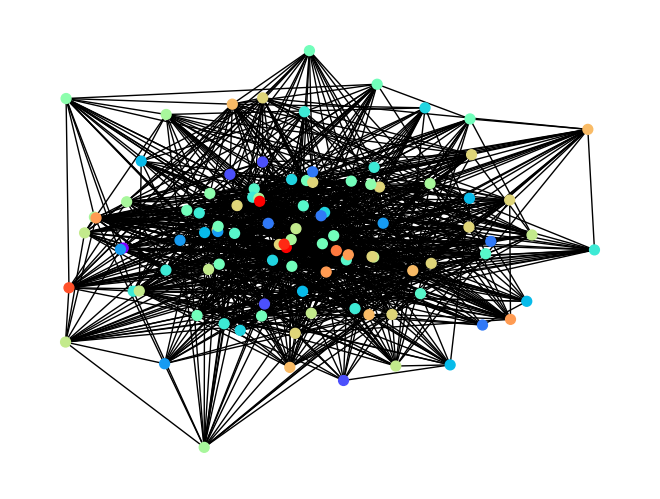

In [18]:
scaled_degree = [d[1]*50 for d in nx.degree(protein_network)]
nx.draw_kamada_kawai(protein_network,
        # Weights Based on Column
        width=list(nx.get_edge_attributes(protein_network, 'SemSim').values()),
        # Node size based on degree
        node_size=50,
        # Colour Based on Degree
        node_color=scaled_degree,
        # Set color map to determine colours
        cmap='rainbow',
        with_labels=False)

## Applying Persistent Homology (Rips Persistence via Ripser)
**ripser** package was very useful when analysing networks relying solely on a distance matrix of shortest paths for each node pairs (Floyd-Warshall). It does not allow much flexibility when exploring filtrations set to edge weights.

## Using the Adjacency Matrix

In [19]:
pn_adjacency = nx.adjacency_matrix(protein_network).toarray()

/opt/homebrew/lib/python3.11/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(


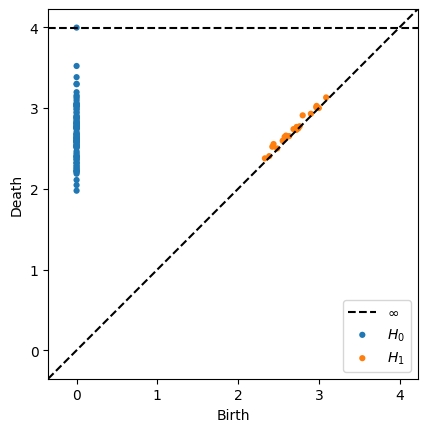

In [20]:
pn_diagrams = ripser.ripser(pn_adjacency, distance_matrix=False)['dgms']
plot_diagrams(pn_diagrams)

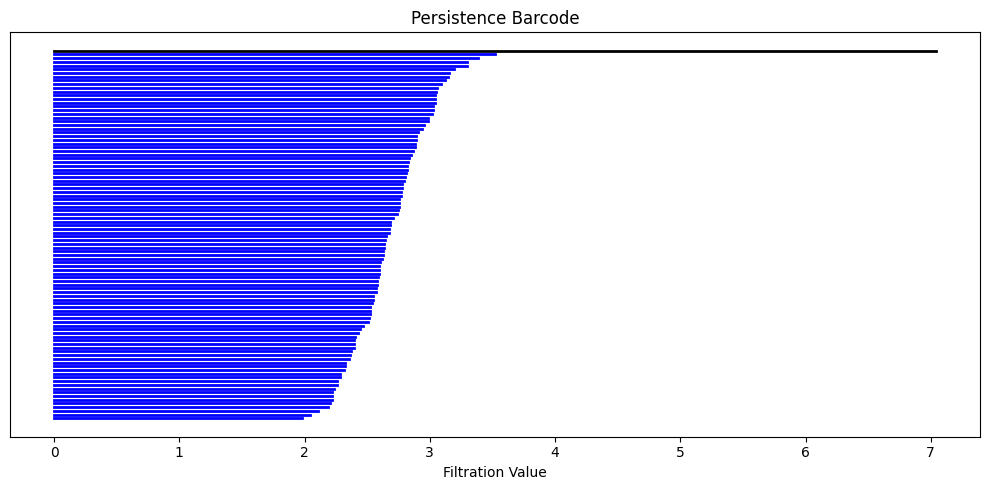

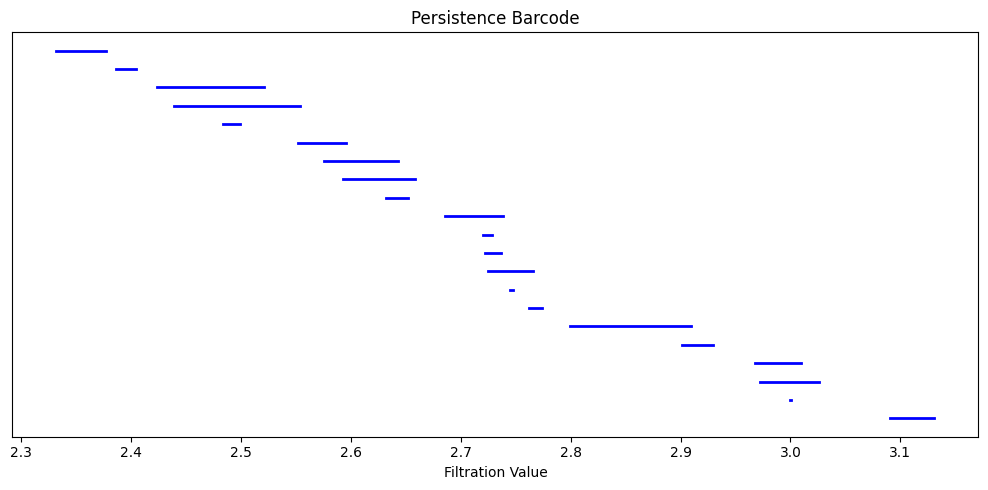

In [21]:
## Exploring the Barcode Diagrams for the two Homology ranks 0 and 1
## H_0
plot_barcode(pn_diagrams, 0)
## H_1  
plot_barcode(pn_diagrams, 1)

## Using FloydWarshall Pair Distances Matrix

In [22]:
pn_distance = np.array(nx.floyd_warshall_numpy(protein_network))
pn_distance

array([[0.        , 0.31196362, 0.32960988, ..., 0.18567105, 0.42321968,
        0.34380852],
       [0.31196362, 0.        , 0.34737926, ..., 0.21949005, 0.31131286,
        0.13560646],
       [0.32960988, 0.34737926, 0.        , ..., 0.29308747, 0.48415341,
        0.35966926],
       ...,
       [0.18567105, 0.21949005, 0.29308747, ..., 0.        , 0.2902017 ,
        0.27066662],
       [0.42321968, 0.31131286, 0.48415341, ..., 0.2902017 , 0.        ,
        0.24190094],
       [0.34380852, 0.13560646, 0.35966926, ..., 0.27066662, 0.24190094,
        0.        ]])

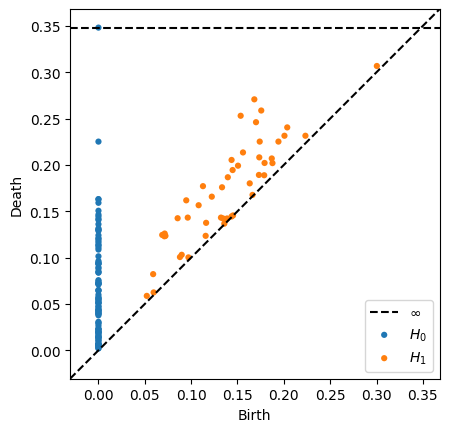

In [23]:
pn_mat_diagrams = ripser.ripser(pn_distance, distance_matrix=True)['dgms']
plot_diagrams(pn_mat_diagrams)

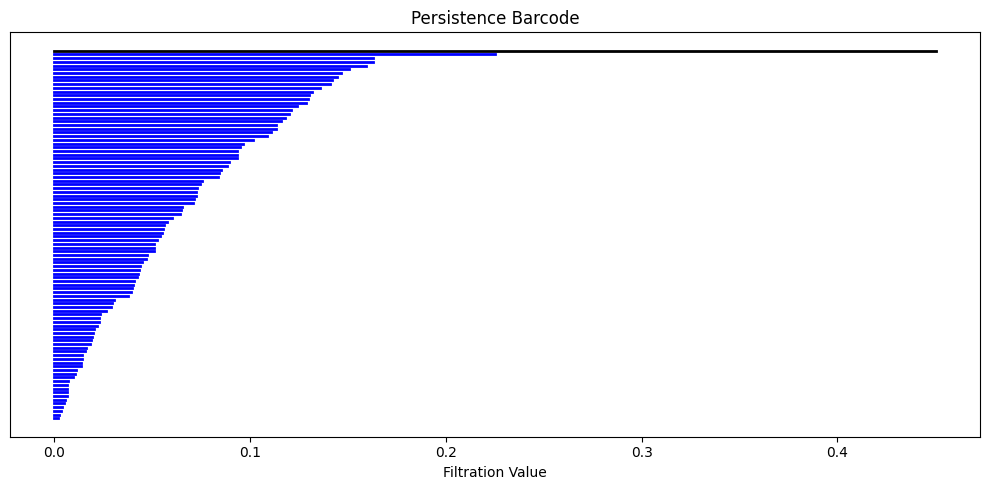

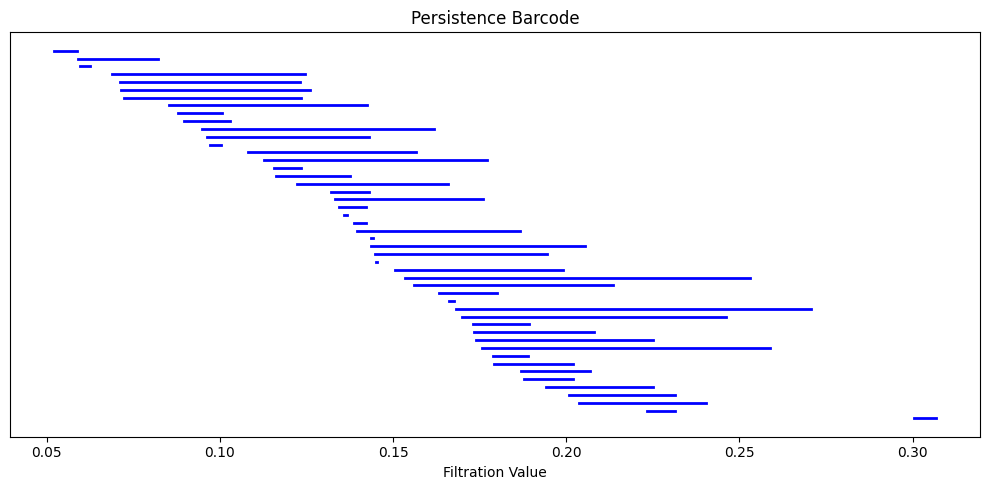

In [24]:
## Exploring the Barcode Diagrams for the two Homology ranks 0 and 1
## H_0
plot_barcode(pn_mat_diagrams, 0)
## H_1  
plot_barcode(pn_mat_diagrams, 1)

## Gudhi Persistent Homology Analysis and Clustering

### Simplex Tree Construction

In [25]:
## Let's store the proteins in an indexed dictionary so we could track them back when building the simplex tree
proteins_dict = {protein: idx for idx, protein in enumerate(proteins)}

In [26]:
# Given protein-protein interaction network we can start by creating a simplex tree that includes all 0-simplices (nodes)

# Construct a simplex tree from the network
simplex_tree = gd.SimplexTree()

for edge in protein_network.edges(data=True):
    node1, node2, weight = edge
    ## Get protein index from dict to map it back and feed it into the simplex tree
    node1_idx = proteins_dict[node1]
    node2_idx = proteins_dict[node2]
    simplex_tree.insert([node1_idx, node2_idx], filtration=weight['weight'])



### Persistent Homology

/opt/homebrew/lib/python3.11/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


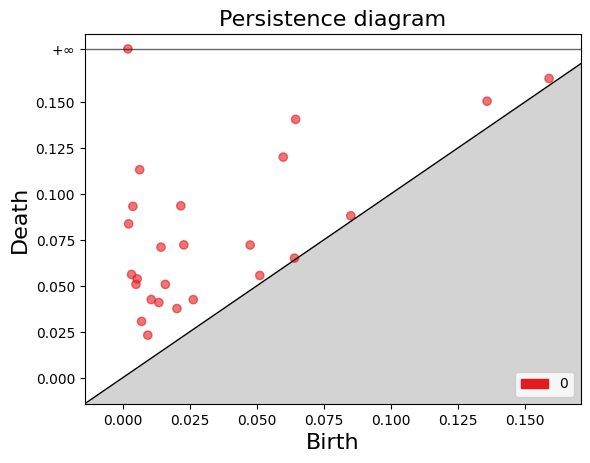

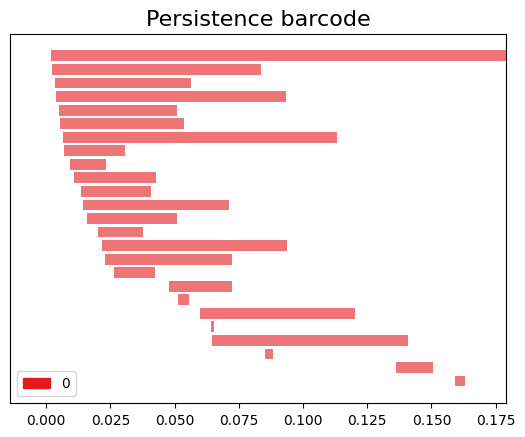

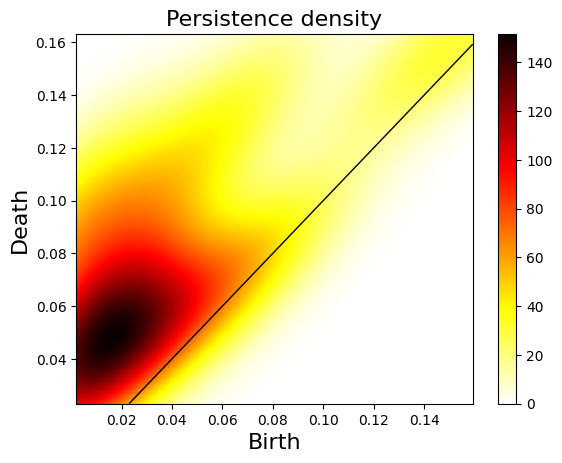

In [27]:
# Compute persistence diagrams
## NOTE: min_persistence is set to -1 to view all the simplex values (Include all 0-simplices)

persistence = simplex_tree.persistence(min_persistence=0, persistence_dim_max=False)

# Generate persistence diagrams
diagrams = gd.plot_persistence_diagram(persistence)
barcode = gd.plot_persistence_barcode(persistence)
density = gd.plot_persistence_density(persistence)

### Exploring Simplices in Simplex Tree

In [48]:
smplx_tree_gen = simplex_tree.get_filtration()

In [ ]:
for smplx in smplx_tree_gen:
    if(len(smplx[0]) == 1):
        print(smplx)

#if len(smplx[0] == 1):

In [68]:
simplex_tree.dimension()

1

In [69]:
simplex_tree.num_simplices()

861

In [50]:
simplex_tree.num_vertices()

100

### Feature Extraction and Clustering

In [52]:
## death values of np.inf would not give us a measure to cluster them with DBSCAN, so let's set a cap death time for those to a max value of 1
for i, pt in enumerate(persistence):
    if pt[1][1] == np.inf:
        pt = list(pt)
        pt[1] = list(pt[1])
        pt[1][1] = 1
        pt[1] = tuple(pt[1])
        persistence[i] = tuple(pt)
        #print(pt)

In [53]:

# Extract features from the persistence diagrams
# I will use just the birth and death times of the topological features for now and see how DBSCAN would perfrom in the clustering
features = np.array([[pt[1][0], pt[1][1]] for pt in persistence])


# Cluster the proteins into complexes using DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)
dbscan.fit(features)

# Get the predicted labels (complexes)
predicted_labels = dbscan.labels_


In [54]:
## TESTING 
predicted_labels

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [1]:
# Print predicted complexes
complexes = {}
for i, protein in enumerate(proteins):
    label = predicted_labels[i]
    if label not in complexes:
        complexes[label] = []
    complexes[label].append(protein)

print("Predicted complexes:")
for label, members in complexes.items():
    print(f"Complex {label}: {', '.join(members)}")

NameError: name 'proteins' is not defined

In [55]:
print(len(complex_1))
print(complex_1)

10
['Protein_3', 'Protein_7', 'Protein_13', 'Protein_61', 'Protein_14', 'Protein_69', 'Protein_16', 'Protein_42', 'Protein_26', 'Protein_24']


In [56]:
print(len(complex_2))
print(complex_2)

7
['Protein_99', 'Protein_20', 'Protein_56', 'Protein_34', 'Protein_16', 'Protein_52', 'Protein_83']


In [57]:
print(len(complex_3))
print(complex_3)

5
['Protein_21', 'Protein_27', 'Protein_32', 'Protein_76', 'Protein_56']


### DBSCAN Parameter Estimation

In [ ]:
x = []
for pt in persistence:
    x.append(list(pt[1]))
x

In [59]:
# Calculate k-nearest neighbors epsilon-distances 
def calculate_kn_distance(X,k):
    kn_distance = []
    for i in range(len(X)):
        eucl_dist = []
        for j in range(len(X)):
            eucl_dist.append(
                math.sqrt(
                    ((X[i][0] - X[j][0]) ** 2) +
                    ((X[i][1] - X[j][1]) ** 2)))

        eucl_dist.sort()
        kn_distance.append(eucl_dist[k])

    return kn_distance

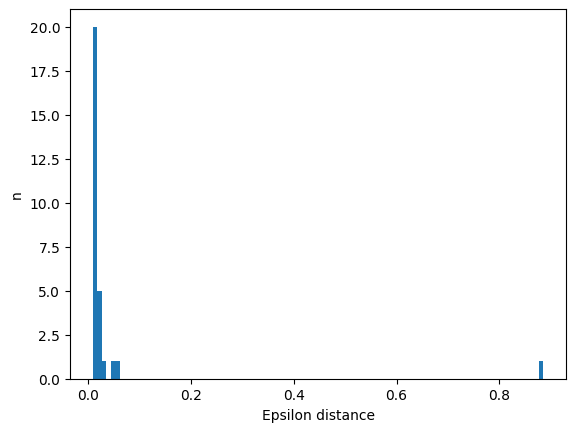

In [62]:
## Plot eps_distances
eps_dist = calculate_kn_distance(x,3)
plt.hist(eps_dist,bins=100)
plt.ylabel('n');
plt.xlabel('Epsilon distance');


## RipsComplex on Distance

In [67]:
distance_mat = 1 - pn_adjacency

In [61]:
trans_adj_mat = np.fill_diagonal(pn_adjacency, 1)

In [66]:
pn_adjacency

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.85619122, 0.95492993,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.6518609 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.85619122, 0.6518609 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.95492993, 0.        , ..., 0.        , 1.        ,
        0.24190094],
       [0.        , 0.        , 0.        , ..., 0.        , 0.24190094,
        1.        ]])

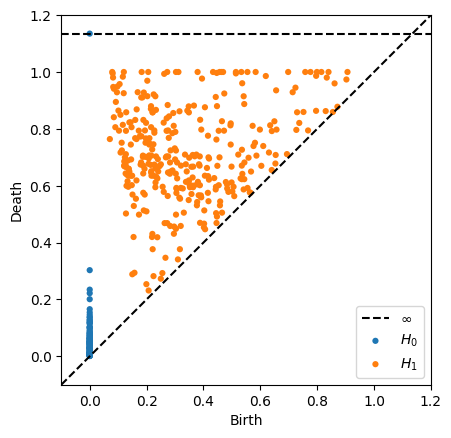

In [68]:
dist_mat_diags_ripser = ripser.ripser(distance_mat, distance_matrix=True)['dgms']
plot_diagrams(dist_mat_diags_ripser)

In [70]:
len(dist_mat_diags_ripser[1])

344

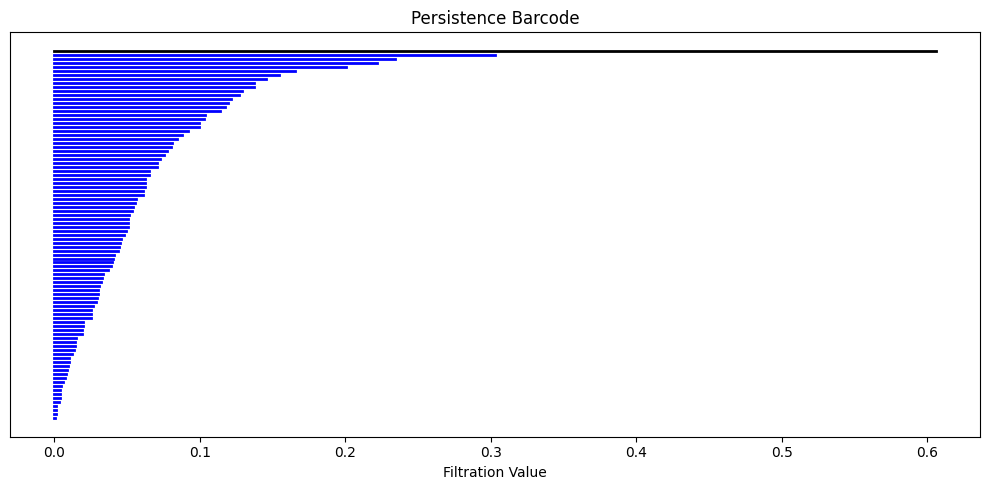

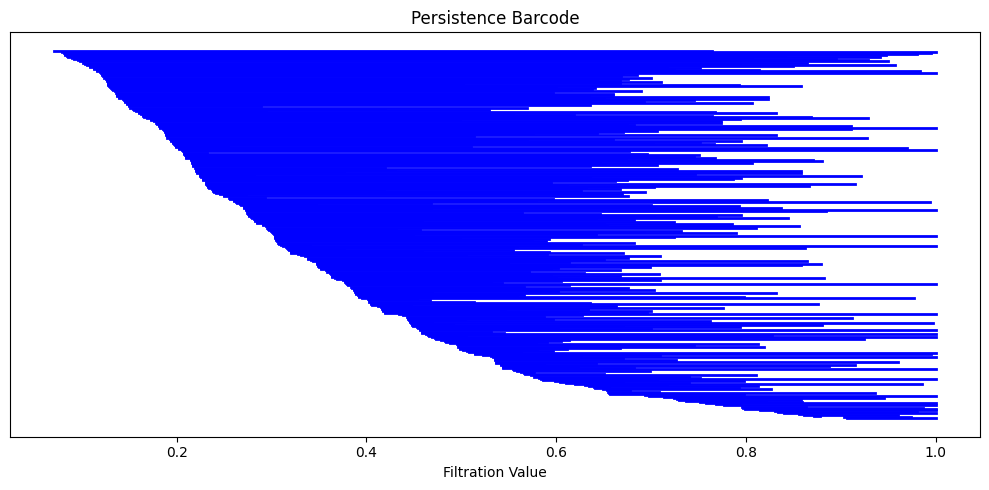

In [72]:
plot_barcode(dist_mat_diags_ripser, 0)
plot_barcode(dist_mat_diags_ripser, 1)

In [75]:
pers_features = []
for diag in dist_mat_diags_ripser[1]:
    birth = diag[0]
    death = diag[1]
    if (death - birth >= 0.5):
        pers_features.append(diag)

In [77]:
len(pers_features)

108